In [1]:
import numpy as np
import json
from scipy.stats import pearsonr

In [2]:
# Define the paths to the JSON files
violin_motion_features_path = '/home/gabriel/theo/masters-thesis/dataset/Bhargavi Chandrasekar/Challare Rmachandru/violin/violin_motion_features.json'
motion_features_path = '/home/gabriel/theo/masters-thesis/dataset/Bhargavi Chandrasekar/Challare Rmachandru/violin/motion_features.json'
audio_features_path = '/home/gabriel/theo/masters-thesis/dataset/Bhargavi Chandrasekar/Challare Rmachandru/violin/audio_features.json'

# Load the violin motion features from the JSON file
with open(violin_motion_features_path, 'r') as f:
    violin_motion_features = json.load(f)

# Load the motion features from the JSON file
with open(motion_features_path, 'r') as f:
    motion_features = json.load(f)

# Load the audio features from the JSON file
with open(audio_features_path, 'r') as f:
    audio_features = json.load(f)

In [3]:
def safe_pearsonr(x, y):
    """
    Compute Pearson correlation between x and y, ignoring NaNs.

    Returns (corr, pval). If too few valid values, returns (np.nan, np.nan).
    """
    x = np.array(x)
    y = np.array(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < 2:  # need at least 2 points to compute correlation
        return np.nan, np.nan
    return pearsonr(x[mask], y[mask])

In [4]:
def sliding_correlation(
    signal1, signal2, window_size, step_size, fps, threshold=0.3
):
    assert len(signal1) == len(signal2), "Signals must be the same length"

    correlations = []
    pvals = []
    times = []
    for start in range(0, len(signal1) - window_size + 1, step_size):
        end = start + window_size
        seg1 = signal1[start:end]
        seg2 = signal2[start:end]

        corr, pval = safe_pearsonr(seg1, seg2)
        correlations.append(corr)
        pvals.append(pval)
        times.append(start / fps)

    strong_corr_times = [
        (t,c)
        for t, c, p in zip(times, correlations, pvals)
        if not np.isnan(p)
        and p < 0.05
        and not np.isnan(c)
        and abs(c) > threshold
    ]

    return np.array(correlations), np.array(times), strong_corr_times

In [5]:
artist = "Bhargavi Chandrasekar"
song = "Challare Rmachandru" 
instrument = "violin"

In [15]:
# Motion features we want to analyze
motion_features_to_analyze = ["mean_speed", "mean_acceleration"]

# Initialize results dictionary
general_strong_windows = {
    artist: {
        song: {
            instrument: {}
        }
    }
}

fps = 30
window_size = int(0.5 * fps)  # 0.5 second windows
step_size = int(0.1 * fps)    # 0.1 second steps

print(f"Analyzing {artist} - {song} - {instrument}")
print(f"Window size: {window_size} frames ({window_size/fps:.1f}s)")
print(f"Step size: {step_size} frames ({step_size/fps:.1f}s)")

# Get the audio features for this song
audio_onset_env = audio_features["onset_env"]
audio_rms = audio_features["rms"]

for motion_feature in motion_features_to_analyze:
    if motion_feature not in general_strong_windows[artist][song][instrument]:
        general_strong_windows[artist][song][instrument][motion_feature] = {}
    
    print(f"\nAnalyzing {motion_feature}...")
    
    # Get the motion feature data
    motion_data = motion_features["general"][motion_feature]
    
    # Compute sliding correlation with onset_env
    correlations_onset, times_onset, strong_correlation_windows_onset = sliding_correlation(
        motion_data,
        audio_onset_env,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Compute sliding correlation with rms
    correlations_rms, times_rms, strong_correlation_windows_rms = sliding_correlation(
        motion_data,
        audio_rms,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Store results
    general_strong_windows[artist][song][instrument][motion_feature] = {
        "correlations_onset": correlations_onset.tolist(),
        "times_onset": times_onset.tolist(), 
        "strong_windows_onset": strong_correlation_windows_onset,
        "num_strong_windows_onset": len(strong_correlation_windows_onset),
        "correlations_rms": correlations_rms.tolist(),
        "times_rms": times_rms.tolist(), 
        "strong_windows_rms": strong_correlation_windows_rms,
        "num_strong_windows_rms": len(strong_correlation_windows_rms)
    }
    
    print(f"Found {len(strong_correlation_windows_onset)} strong correlation windows for {motion_feature} (onset_env)")
    if strong_correlation_windows_onset:
        print("Strong correlation periods (onset_env):")
        for time, corr in strong_correlation_windows_onset:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

    print(f"Found {len(strong_correlation_windows_rms)} strong correlation windows for {motion_feature} (rms)")
    if strong_correlation_windows_rms:
        print("Strong correlation periods (rms):")
        for time, corr in strong_correlation_windows_rms:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

Analyzing Bhargavi Chandrasekar - Challare Rmachandru - violin
Window size: 15 frames (0.5s)
Step size: 3 frames (0.1s)

Analyzing mean_speed...
Found 93 strong correlation windows for mean_speed (onset_env)
Strong correlation periods (onset_env):
  Time: 0.80s, Correlation: 0.601
  Time: 2.20s, Correlation: -0.641
  Time: 6.40s, Correlation: -0.525
  Time: 6.50s, Correlation: -0.531
  Time: 6.60s, Correlation: -0.695
  Time: 12.50s, Correlation: 0.569
  Time: 25.60s, Correlation: -0.547
  Time: 25.70s, Correlation: -0.761
  Time: 30.70s, Correlation: 0.620
  Time: 40.60s, Correlation: 0.599
  Time: 41.10s, Correlation: 0.516
  Time: 45.30s, Correlation: 0.530
  Time: 45.40s, Correlation: 0.557
  Time: 45.50s, Correlation: 0.645
  Time: 45.60s, Correlation: 0.615
  Time: 46.20s, Correlation: 0.551
  Time: 46.30s, Correlation: 0.531
  Time: 47.50s, Correlation: -0.606
  Time: 47.60s, Correlation: -0.604
  Time: 47.70s, Correlation: -0.598
  Time: 48.00s, Correlation: 0.614
  Time: 53.00

In [17]:
# Motion features we want to analyze
motion_features_to_analyze = ["wrist_speed", "elbow_angle", "arm_extension"]

# Initialize results dictionary
violin_strong_windows = {
    artist: {
        song: {
            instrument: {}
        }
    }
}

fps = 30
window_size = int(0.5 * fps)  # 0.5 second windows
step_size = int(0.1 * fps)    # 0.1 second steps

print(f"Analyzing {artist} - {song} - {instrument}")
print(f"Window size: {window_size} frames ({window_size/fps:.1f}s)")
print(f"Step size: {step_size} frames ({step_size/fps:.1f}s)")

# Get the audio features
audio_onset_env = audio_features["onset_env"]
audio_rms = audio_features["rms"]

for motion_feature in motion_features_to_analyze:
    if motion_feature not in violin_strong_windows[artist][song][instrument]:
        violin_strong_windows[artist][song][instrument][motion_feature] = {}
    
    print(f"\nAnalyzing {motion_feature}...")
    
    # Get the motion feature data
    motion_data = violin_motion_features[motion_feature]
    
    # Compute sliding correlation with onset_env
    correlations_onset, times_onset, strong_correlation_windows_onset = sliding_correlation(
        motion_data,
        audio_onset_env,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Compute sliding correlation with rms
    correlations_rms, times_rms, strong_correlation_windows_rms = sliding_correlation(
        motion_data,
        audio_rms,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Store results
    violin_strong_windows[artist][song][instrument][motion_feature] = {
        "correlations_onset": correlations_onset.tolist(),
        "times_onset": times_onset.tolist(),
        "strong_windows_onset": strong_correlation_windows_onset,
        "num_strong_windows_onset": len(strong_correlation_windows_onset),
        "correlations_rms": correlations_rms.tolist(),
        "times_rms": times_rms.tolist(),
        "strong_windows_rms": strong_correlation_windows_rms,
        "num_strong_windows_rms": len(strong_correlation_windows_rms)
    }
    
    print(f"Found {len(strong_correlation_windows_onset)} strong correlation windows for {motion_feature} (onset_env)")
    if strong_correlation_windows_onset:
        print("Strong correlation periods (onset_env):")
        for time, corr in strong_correlation_windows_onset:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

    print(f"Found {len(strong_correlation_windows_rms)} strong correlation windows for {motion_feature} (rms)")
    if strong_correlation_windows_rms:
        print("Strong correlation periods (rms):")
        for time, corr in strong_correlation_windows_rms:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

Analyzing Bhargavi Chandrasekar - Challare Rmachandru - violin
Window size: 15 frames (0.5s)
Step size: 3 frames (0.1s)

Analyzing wrist_speed...
Found 108 strong correlation windows for wrist_speed (onset_env)
Strong correlation periods (onset_env):
  Time: 0.60s, Correlation: -0.570
  Time: 1.90s, Correlation: 0.563
  Time: 11.10s, Correlation: -0.523
  Time: 11.20s, Correlation: -0.694
  Time: 12.70s, Correlation: 0.653
  Time: 12.80s, Correlation: 0.720
  Time: 12.90s, Correlation: 0.793
  Time: 13.00s, Correlation: 0.744
  Time: 13.10s, Correlation: 0.559
  Time: 19.40s, Correlation: 0.663
  Time: 24.80s, Correlation: 0.649
  Time: 24.90s, Correlation: 0.677
  Time: 25.00s, Correlation: 0.586
  Time: 25.10s, Correlation: 0.571
  Time: 25.20s, Correlation: 0.524
  Time: 25.80s, Correlation: -0.564
  Time: 29.90s, Correlation: 0.517
  Time: 33.20s, Correlation: 0.554
  Time: 33.30s, Correlation: 0.555
  Time: 36.20s, Correlation: 0.517
  Time: 36.30s, Correlation: 0.538
  Time: 37.1


CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS

WRIST_SPEED COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: 0.004
    Max correlation: 0.869
    Strong correlation windows: 108
    % of time with strong correlation: 6.7%
  RMS ENERGY:
    Mean correlation: 0.065
    Max correlation: 0.918
    Strong correlation windows: 253
    % of time with strong correlation: 15.7%
  → RMS energy shows better correlation (15.7% vs 6.7%)

ELBOW_ANGLE COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.004
    Max correlation: 0.924
    Strong correlation windows: 82
    % of time with strong correlation: 5.1%
  RMS ENERGY:
    Mean correlation: -0.113
    Max correlation: 0.977
    Strong correlation windows: 732
    % of time with strong correlation: 45.4%
  → RMS energy shows better correlation (45.4% vs 5.1%)

ARM_EXTENSION COMPARISON:
  ONSET ENVELOPE:

ELBOW_ANGLE COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.004
    Max correlation: 0.924
    Strong correlation windows: 82
   

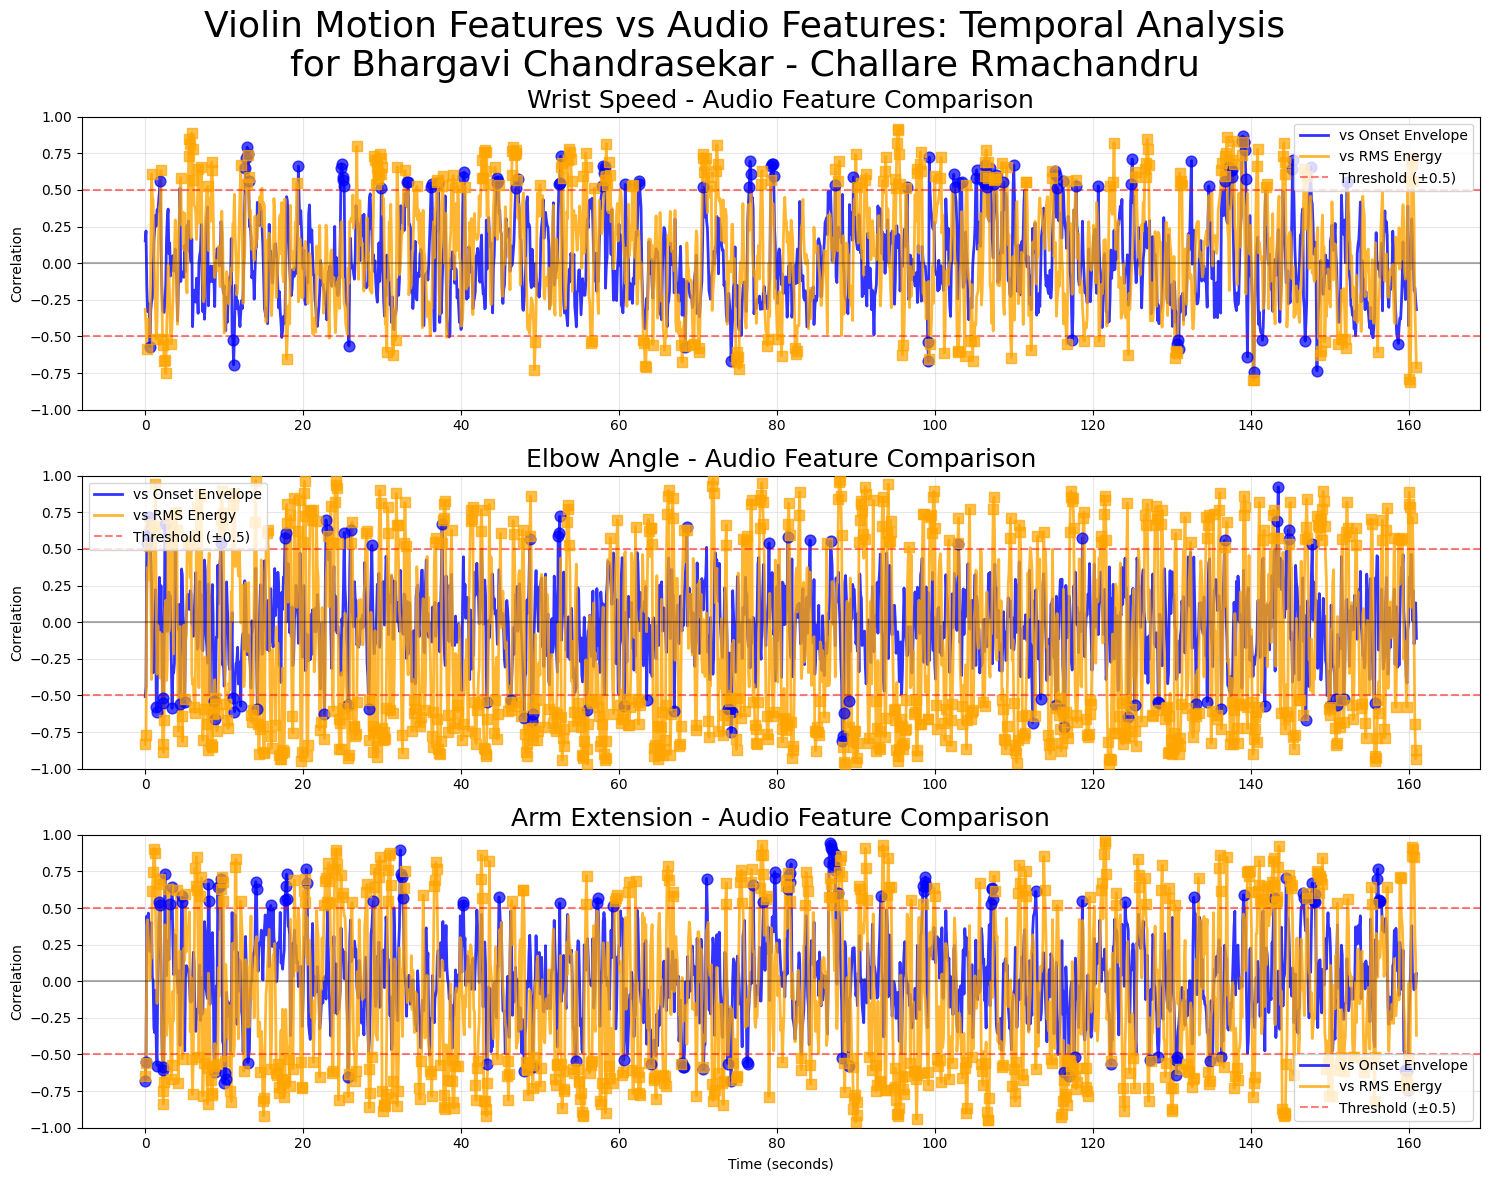


OVERALL AUDIO FEATURE COMPARISON SUMMARY
Total strong correlation windows:
  Onset Envelope: 313
  RMS Energy: 1532

✓ RMS Energy overall shows better correlation with violin motion features!


In [21]:
# Summary and visualization of results with onset env and RMS overlay
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS")
print("="*60)

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle(f'Violin Motion Features vs Audio Features: Temporal Analysis\nfor {artist} - {song}', fontsize=26)

for i, motion_feature in enumerate(motion_features_to_analyze):
    results = violin_strong_windows[artist][song][instrument][motion_feature]
    
    ax = axes[i]
    
    # Plot both onset and RMS correlations
    ax.plot(results["times_onset"], results["correlations_onset"], 
            alpha=0.8, linewidth=2, color='blue', label='vs Onset Envelope')
    ax.plot(results["times_rms"], results["correlations_rms"], 
            alpha=0.8, linewidth=2, color='orange', label='vs RMS Energy')
    
    # Threshold lines
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold (±0.5)')
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows with different markers
    for time, corr in results["strong_windows_onset"]:
        ax.scatter(time, corr, color='blue', s=60, zorder=5, marker='o', alpha=0.7)
    
    for time, corr in results["strong_windows_rms"]:
        ax.scatter(time, corr, color='orange', s=60, zorder=5, marker='s', alpha=0.7)
    
    ax.set_title(f'{motion_feature.replace("_", " ").title()} - Audio Feature Comparison', fontsize=18)
    if i == 2: ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(-1, 1)
    
    # Print summary statistics for both audio features
    correlations_onset = np.array(results["correlations_onset"])
    correlations_rms = np.array(results["correlations_rms"])
    
    print(f"\n{motion_feature.upper()} COMPARISON:")
    print(f"  ONSET ENVELOPE:")
    print(f"    Mean correlation: {np.nanmean(correlations_onset):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_onset):.3f}")
    print(f"    Strong correlation windows: {results['num_strong_windows_onset']}")
    print(f"    % of time with strong correlation: {results['num_strong_windows_onset'] / len(correlations_onset) * 100:.1f}%")
    
    print(f"  RMS ENERGY:")
    print(f"    Mean correlation: {np.nanmean(correlations_rms):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_rms):.3f}")
    print(f"    Strong correlation windows: {results['num_strong_windows_rms']}")
    print(f"    % of time with strong correlation: {results['num_strong_windows_rms'] / len(correlations_rms) * 100:.1f}%")
    
    # Determine which audio feature correlates better
    onset_pct = results['num_strong_windows_onset'] / len(correlations_onset) * 100
    rms_pct = results['num_strong_windows_rms'] / len(correlations_rms) * 100
    
    if rms_pct > onset_pct:
        print(f"  → RMS energy shows better correlation ({rms_pct:.1f}% vs {onset_pct:.1f}%)")
    else:
        print(f"  → Onset envelope shows better correlation ({onset_pct:.1f}% vs {rms_pct:.1f}%)")

plt.tight_layout()
plt.show()

# Overall comparison summary
print(f"\n{'='*60}")
print("OVERALL AUDIO FEATURE COMPARISON SUMMARY")
print(f"{'='*60}")

total_onset_windows = sum(violin_strong_windows[artist][song][instrument][feat]['num_strong_windows_onset'] 
                         for feat in motion_features_to_analyze)
total_rms_windows = sum(violin_strong_windows[artist][song][instrument][feat]['num_strong_windows_rms'] 
                       for feat in motion_features_to_analyze)

print(f"Total strong correlation windows:")
print(f"  Onset Envelope: {total_onset_windows}")
print(f"  RMS Energy: {total_rms_windows}")

if total_rms_windows > total_onset_windows:
    print(f"\n✓ RMS Energy overall shows better correlation with violin motion features!")
else:
    print(f"\n✓ Onset Envelope overall shows better correlation with violin motion features!")


COMPARISON: GENERAL vs VIOLIN-SPECIFIC MOTION FEATURES


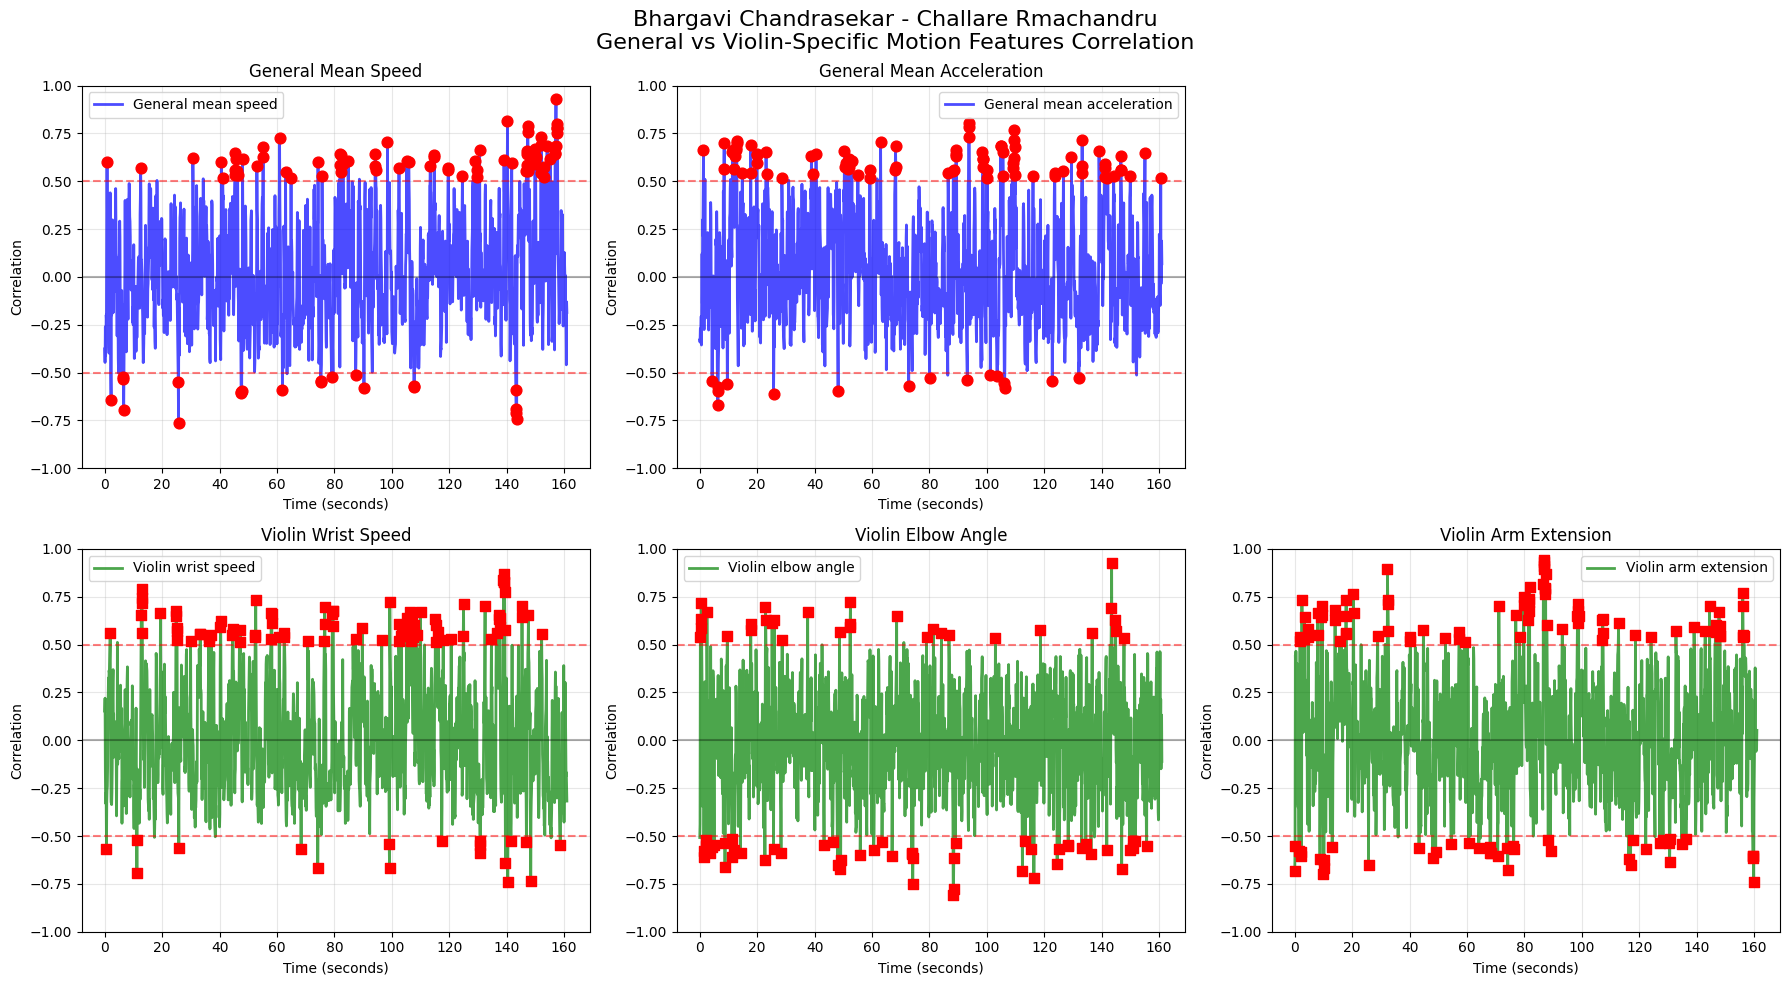

In [10]:
# Comparison analysis: General vs Violin-specific motion features
print("\n" + "="*80)
print("COMPARISON: GENERAL vs VIOLIN-SPECIFIC MOTION FEATURES")
print("="*80)

# Get results from both analyses (assuming they're stored in different variables)
# General motion features results (from cell 5)
general_features = ["mean_speed", "mean_acceleration"]
violin_features = ["wrist_speed", "elbow_angle", "arm_extension"]

# Create comparison data structure
comparison_data = {}

# Add general motion features data
for feature in general_features:
    motion_data = motion_features["general"][feature]
    correlations, times, strong_windows_list = sliding_correlation(
        motion_data, audio_onset_env, window_size, step_size, fps, threshold=0.5
    )
    comparison_data[f"general_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "general"
    }

# Add violin-specific motion features data
for feature in violin_features:
    motion_data = violin_motion_features[feature]
    correlations, times, strong_windows_list = sliding_correlation(
        motion_data, audio_onset_env, window_size, step_size, fps, threshold=0.5
    )
    comparison_data[f"violin_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "violin"
    }

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'{artist} - {song}\nGeneral vs Violin-Specific Motion Features Correlation', fontsize=16)

# Plot general features in top row
for i, feature in enumerate(general_features):
    ax = axes[0, i]
    data = comparison_data[f"general_{feature}"]
    
    ax.plot(data["times"], data["correlations"], alpha=0.7, linewidth=2, 
            color='blue', label=f'General {feature.replace("_", " ")}')
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color='red', s=60, zorder=5, marker='o')
    
    ax.set_title(f'General {feature.replace("_", " ").title()}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    ax.legend()

# Hide the third subplot in top row
axes[0, 2].axis('off')

# Plot violin features in bottom row
for i, feature in enumerate(violin_features):
    ax = axes[1, i]
    data = comparison_data[f"violin_{feature}"]
    
    ax.plot(data["times"], data["correlations"], alpha=0.7, linewidth=2, 
            color='green', label=f'Violin {feature.replace("_", " ")}')
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color='red', s=60, zorder=5, marker='s')
    
    ax.set_title(f'Violin {feature.replace("_", " ").title()}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.show()


OVERLAY COMPARISON & STATISTICS


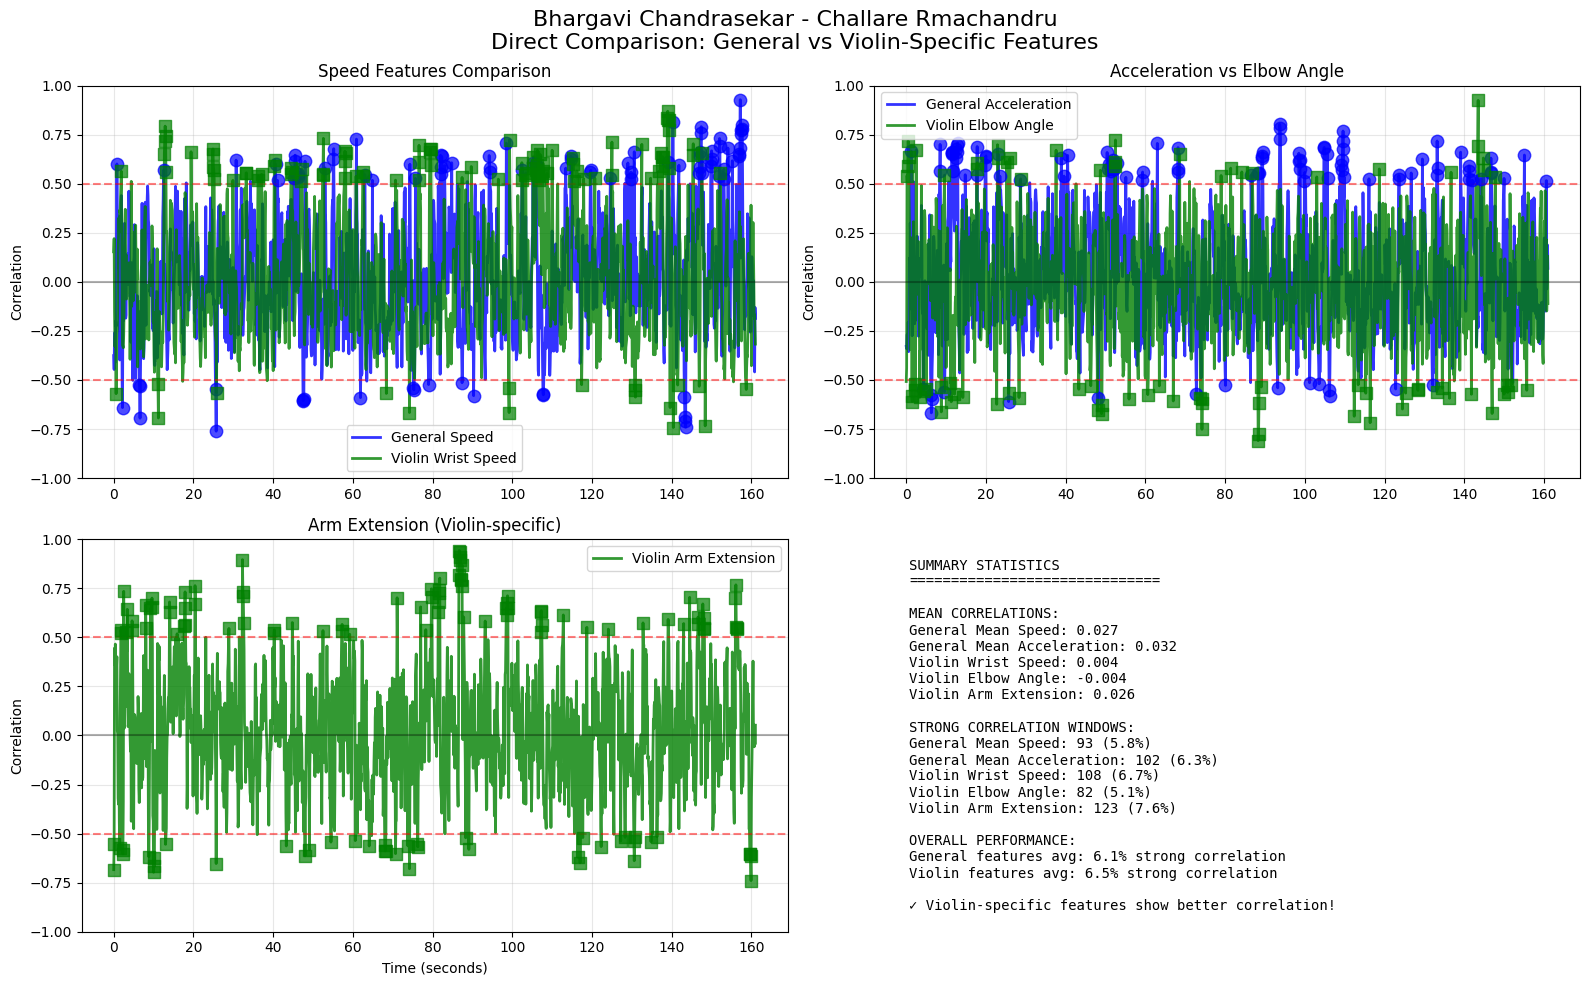


Comparison complete! The plots show:
- Top row: Direct overlay comparisons of similar feature types
- Bottom left: Unique violin feature (arm extension)
- Bottom right: Summary statistics and performance comparison


In [11]:
# Direct overlay comparison and summary statistics
print("\n" + "="*80)
print("OVERLAY COMPARISON & STATISTICS")
print("="*80)

# Create overlay plots comparing similar features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'{artist} - {song}\nDirect Comparison: General vs Violin-Specific Features', fontsize=16)

# Speed comparison (general mean_speed vs violin wrist_speed)
ax1 = axes[0, 0]
general_speed = comparison_data["general_mean_speed"]
violin_speed = comparison_data["violin_wrist_speed"]

ax1.plot(general_speed["times"], general_speed["correlations"], 
         alpha=0.8, linewidth=2, color='blue', label='General Speed')
ax1.plot(violin_speed["times"], violin_speed["correlations"], 
         alpha=0.8, linewidth=2, color='green', label='Violin Wrist Speed')

# Mark strong correlations with different markers
for time, corr in general_speed["strong_windows"]:
    ax1.scatter(time, corr, color='blue', s=80, zorder=5, marker='o', alpha=0.7)
for time, corr in violin_speed["strong_windows"]:
    ax1.scatter(time, corr, color='green', s=80, zorder=5, marker='s', alpha=0.7)

ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax1.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.set_title('Speed Features Comparison')
ax1.set_ylabel('Correlation')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(-1, 1)

# Acceleration vs Elbow Angle comparison
ax2 = axes[0, 1]
general_accel = comparison_data["general_mean_acceleration"]
violin_elbow = comparison_data["violin_elbow_angle"]

ax2.plot(general_accel["times"], general_accel["correlations"], 
         alpha=0.8, linewidth=2, color='blue', label='General Acceleration')
ax2.plot(violin_elbow["times"], violin_elbow["correlations"], 
         alpha=0.8, linewidth=2, color='green', label='Violin Elbow Angle')

for time, corr in general_accel["strong_windows"]:
    ax2.scatter(time, corr, color='blue', s=80, zorder=5, marker='o', alpha=0.7)
for time, corr in violin_elbow["strong_windows"]:
    ax2.scatter(time, corr, color='green', s=80, zorder=5, marker='s', alpha=0.7)

ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax2.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_title('Acceleration vs Elbow Angle')
ax2.set_ylabel('Correlation')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(-1, 1)

# Arm Extension (unique to violin features)
ax3 = axes[1, 0]
violin_arm = comparison_data["violin_arm_extension"]

ax3.plot(violin_arm["times"], violin_arm["correlations"], 
         alpha=0.8, linewidth=2, color='green', label='Violin Arm Extension')

for time, corr in violin_arm["strong_windows"]:
    ax3.scatter(time, corr, color='green', s=80, zorder=5, marker='s', alpha=0.7)

ax3.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax3.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.set_title('Arm Extension (Violin-specific)')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Correlation')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(-1, 1)

# Summary statistics comparison
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate summary statistics
stats_text = "SUMMARY STATISTICS\n" + "="*30 + "\n\n"

feature_stats = {}
for feature_name, data in comparison_data.items():
    corrs = np.array(data["correlations"])
    feature_stats[feature_name] = {
        'mean_corr': np.nanmean(corrs),
        'max_corr': np.nanmax(corrs),
        'strong_windows': len(data["strong_windows"]),
        'pct_strong': len(data["strong_windows"]) / len(corrs) * 100
    }

# Compare general vs violin features
stats_text += "MEAN CORRELATIONS:\n"
for feature, stats in feature_stats.items():
    stats_text += f"{feature.replace('_', ' ').title()}: {stats['mean_corr']:.3f}\n"

stats_text += "\nSTRONG CORRELATION WINDOWS:\n"
for feature, stats in feature_stats.items():
    stats_text += f"{feature.replace('_', ' ').title()}: {stats['strong_windows']} ({stats['pct_strong']:.1f}%)\n"

# Determine which features perform better
general_avg = np.mean([feature_stats['general_mean_speed']['pct_strong'], 
                      feature_stats['general_mean_acceleration']['pct_strong']])
violin_avg = np.mean([feature_stats['violin_wrist_speed']['pct_strong'],
                     feature_stats['violin_elbow_angle']['pct_strong'],
                     feature_stats['violin_arm_extension']['pct_strong']])

stats_text += f"\nOVERALL PERFORMANCE:\n"
stats_text += f"General features avg: {general_avg:.1f}% strong correlation\n"
stats_text += f"Violin features avg: {violin_avg:.1f}% strong correlation\n"

if violin_avg > general_avg:
    stats_text += "\n✓ Violin-specific features show better correlation!"
else:
    stats_text += "\n✓ General features show better correlation."

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("\nComparison complete! The plots show:")
print("- Top row: Direct overlay comparisons of similar feature types")
print("- Bottom left: Unique violin feature (arm extension)")
print("- Bottom right: Summary statistics and performance comparison")